- Google Coraboratory はブラウザから Pythonというプログラミング言語を実行できるオンラインのサービスです．このページ全体を Notebook といいます．Notebook はプログラムのコードを書くためのセルとテキストを書くためのセルからなります．コードが書かれたセルは Ctrl + Enter またはShift + Enter で実行できますが，前者は実行後カーソルがセル内にとどまるのに対して，後者は次のセルに移動します．

In [1]:
#教材で使用するプログラムコードをコピー(=clone)する
import os
!git clone https://github.com/honda-s691470/SHS_NET_orient_for_IORsemi

- 上のセルを実行(クリックしてCtrl + Enter またはShift + Enter)して下記のような表示がでればOKです  
Cloning into 'SHS_NET_orient_for_IORsemi'...  
remote: Enumerating objects: 184, done.  
remote: Counting objects: 100% (51/51), done.  
remote: Compressing objects: 100% (46/46), done.  
remote: Total 184 (delta 21), reused 0 (delta 0), pack-reused 133  
Receiving objects: 100% (184/184), 86.51 MiB | 53.88 MiB/s, done.  
Resolving deltas: 100% (28/28), done.  

- 次に画面左にあるフォルダマーク(下図の赤丸)をクリックしてみましょう  
SHS_NET_orient_for_IORsemiというディレクトリ(=フォルダ)が表示されているはずです。

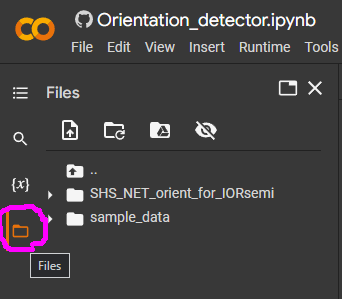

- ディレクトリの中身も見てみましょう  
下図の赤丸の△マークを押すとディレクトリの中身が確認できます。  
SHS_NET_orient_for_IORsemiの中のhand_all_rotationには訓練用のレントゲン画像が約100枚入っています。  
この中のtrain_img10.pngという画像をダブルクリックしてみましょう

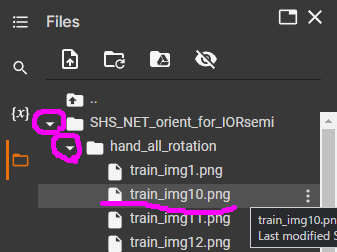

- そうすると画面右側に画像が表示されます。  
とても大きいので下図のようにレントゲンの一部しか写っていませんが、スクロールバーを動かすと、全体を確認できます  
全体を確認してもらうと、この手は右手で、左90度回転していることがわかると思います。

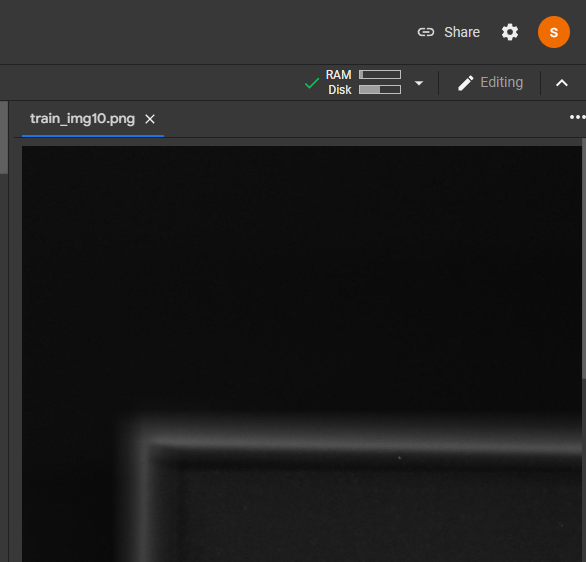

- さて、AIの学習にはさまざまな方法があります。今回は教師あり学習という方法でAIを学習させます。  
簡単に言えば、人間がつけた答えを学習させます。  
逆に答えを与えずにAIだけで答えを導きださせる(=データを分類させる)教師なし学習という手法もあります。  
今回のAIには答えが必要で、それはimage_list_hand_ver3.csvというファイルに入っています。  
これを先ほどと同じようにクリックしてみましょう。すると下図のような表示が画面右側にでてくるはずです。

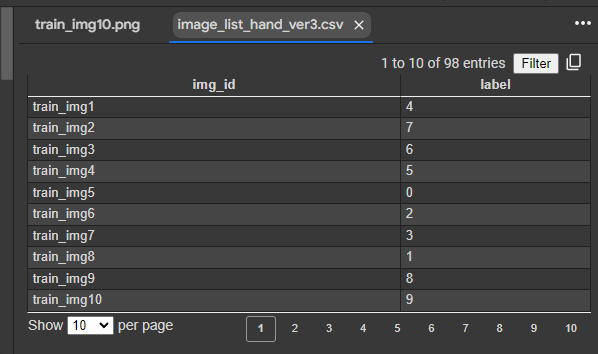

- このcsvファイル(≒エクセルファイル)には、1列目が画像のID(上図のimg_id)、2列目が手の種類と向きの正解番号(上図のlabel)が入っています。  
先程見てもらったtrain_img10.pngという画像の正解は「右手、90度」などではなく「9」という数字が入っています。  
実は、AIはあくまでも数字という形でしか正解が理解できません(言語モデルでさえ言葉をベクトルに置き換えています)。  
なので今回のAIは手の種類と回転に応じて12種類の画像を勉強してもらうため、下図のように0～11の数字を割り振ってます。
右手の左90度回転は下図赤丸のように9番を割り振っています。

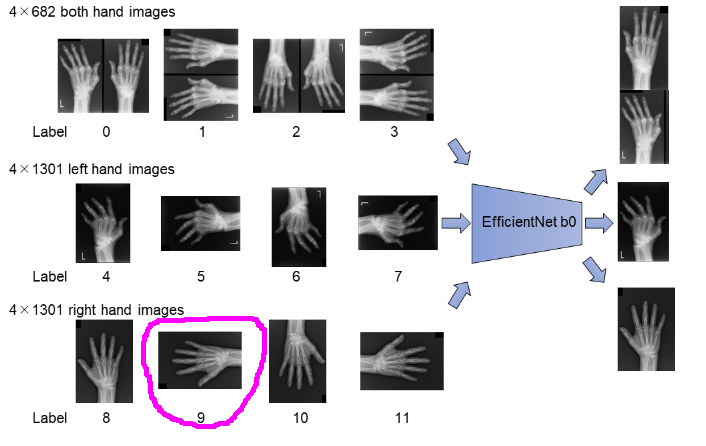

- この他に、hand_testというディレクトリにはテスト用の画像が入っています。  
この場合のテストとは、学習したモデルを使って実際に、画像の向きを直したり、両手の画像は半分に分割できるかどうかをチェックします。  
学習で使った画像をテストで使うと「カンニング」と同じになってしまうため、含めないようにします。
- archs.pyというファイルの中にはさまざまな畳み込みニューラルネットのモデルが入っています。  
このファイルからモデルを読み込んで、このNotebookで学習させます。

- 次に作業しているディレクトリの場所を変えるため、下のセルに書かれたコードを実行しましょう  
path = ''　で''の中に記述されたディレクトリへのパス(path)を定義します。  
os.chdir() でカッコの中に記述されたパスのディレクトリへ移動します。  
!ls　で移動したディレクトリの中にあるファイルを表示しています。  

In [ ]:
path = '/content/SHS_NET_orient_for_IORsemi/'
os.chdir(path)
!ls

- 以下のように表示されればOKです。  
adabound.py	   image_list_hand_ver3.csv    output  
archs.py	   LICENSE		       README.md  
dataset.py	   losses.py		       train_val.py  
hand_all_rotation  Orientation_detector.ipynb  utils.py  
hand_test	   orientation_pred_log  

- さて、下準備が整いました。今から本格的にAIを動かしていきます。  
今回用いるAIは「Python」という言語をつかって組み立てており、この言語を使って指示を行います。  
しかしゼロからすべて記述しているととても膨大な記述を行わなければならず、大変です。  
そこで予めライブラリ(≒本)としてよく使う指示などをまとめておきます。  
実際に指示を記述するときは例えるならPythonという言葉で書かれた＊＊＊という本のXXXという章を参照して！という書き方をします。  
こうすることで記述量を劇的に減らすことができます。  
下のセルにはimportというワードがたくさん見られますが、これは予め、この＊＊＊という本をこれから使いますよ！と宣言しています。  
宣言することで、本の中の章を参照するように指示することができます。

In [2]:
import argparse
from collections import OrderedDict
import numpy as np
from tqdm import tqdm
import pandas as pd
import yaml
import torch
import torch.backends.cudnn as cudnn

- PythonでAIを組み立てるときに最もよくつかうライブラリの一つがPytorchです。(上のセルではimport torchで宣言しています。)  
通常、自分のパソコンでPytorchを使えるようにするには色々なセットアップが必要で、準備が大変です。  
しかし、Google colabでは予めインストールされているため、すぐに使うことができます。  
下のコードを実行して「True」とでれば使用可能です。  
もし出ない場合はNotebook settingsがGPUになってない可能性が高いです。  
左上のEdit→Notebook settings→GPUをセットしてください

In [ ]:
print(torch.cuda.is_available()) 

- 一方で予めインストールされていないライブラリもあります。  
そのような場合は「!pip install ***」とするとgoogle colabにインストールができます。  
下のセルの「timm」は、さまざまなニューラルネットを簡単に参照できるライブラリです。

In [ ]:
!pip install timm

- ライブラリ(≒本)は自作することもできます。  
例えば少しまえにご紹介したarchs.pyというファイルの中身も下のセルのように、 import archs　とすることで参照することができます。

In [4]:
import archs
import losses
from dataset import make_loader
from utils import str2bool, label_maker, optim_maker, scheduler_maker, fig_maker
from train_val import train, val

In [5]:
ARCH_NAMES = archs.__all__
LOSS_NAMES = losses.__all__

さて、AIを学習させる最後のステップになりました。  
下のちょっと長ったらしいセル内ではAIのハイパーパラメータを設定しています。  
パラメータとの違いは何でしょうか？  
パラメータは、予測した数値と正解の数値の差(=誤差)を使ってAIが学習中に更新する変数(特に重みとバイアス)   
ハイパーパラメータは誤差を用いた更新は行われず、人があらかじめ設定しておく変数  
という違いがあります。
なのでハイパーパラメータはAIが学習を始める前に事前に設定しておかなくてはなりません。


まずはそのままの設定（=初期設定)で学習させてみましょう。  
「def parse_args()」 から始まるひとつ下のセルと「def main():」から始まる2つ下のセルを実行してみましょう。  


なにやらたくさん英語が表示されたあと、途中から  
Epoch [1/10]  
100%|██████████| 8/8 [00:04<00:00,  1.90it/s, loss=3.02]  
100%|██████████| 4/4 [00:01<00:00,  2.10it/s, val_loss=900, val_acc=0.1]  
loss 3.0167 - val_loss 899.8346 - val_acc 0.1000 - Number of mistakes 27  
という表示が出てくると思います。  

Epochは学習の回数です。初期設定では10回学習するように設定してあり10回中の何回目の学習なのかが表示されます。
その3つ下の先頭の「loss」は訓練画像の予測値と正解との誤差の総和です。
その隣の「val_loss」は評価画像の予測値と正解の誤差の総和です。  
下のハイパーパラメータの設定で'--test_ratio'を「0.3」にしています。  
このためhand_all_rotationの中に用意した約100枚の画像は70：30の比で訓練(training)画像と評価(validation)画像に分けられます。
AIの学習では訓練画像だけを用いて訓練を行い、訓練中の真のAIの評価は評価画像で行います。テストと同様にカンニングを防止するためです。  
訓練画像はAIが見たことのない画像ですので通常はval_loss＞lossとなります。  
val_accは評価画像での正解率でここでは10%しかありません。実際に間違えた画像の数がNumber of mistakesに記載されています。

10回学習し終わると10回のうちで最もよかった正解率(best_val_acc)と  
その下に各学習回数毎のloss, val_loss, val_accが描かれた学習曲線のグラフが出ると思います。  
初期設定ではおそらくbest_val_accは0.3～0.6くらいになると思います。  
ではどのようにハイパーパラメータを調整したら正解率を向上させられるでしょうか？  
このセミナーではみんなでいろいろハイパーパラメータを変えながら遊んでもらい、結果を議論しながらAIを理解していきます。

In [6]:
def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default=None,
                        help='model name: (default: arch+timestamp)')
    parser.add_argument('--epochs', default=20, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('-b', '--batch_size', default=8, type=int,
                        metavar='N', help='mini-batch size (default: 16)')
    parser.add_argument('--test_ratio', default=0.25, type=float,
                        help='test_ratio')
    
    # model
    parser.add_argument('--arch', '-a', metavar='ARCH', default='Effnet',
                        choices=ARCH_NAMES,
                        help='model architecture: ' +
                        ' | '.join(ARCH_NAMES) +
                        ' (default: Effnet)')
    parser.add_argument('--input_channels', default=3, type=int,
                        help='input channels')
    parser.add_argument('--input_w', default=144, type=int,
                        help='image width')
    parser.add_argument('--input_h', default=144, type=int,
                        help='image height')
    
    # loss
    parser.add_argument('--loss', default='CEL',
                        choices=LOSS_NAMES,
                        help='loss: ' +
                        ' | '.join(LOSS_NAMES) +
                        ' (default: CEL)')

    # dataset
    parser.add_argument('--dataset', default='hand_all_rotation', 
                        help='dataset name')
    parser.add_argument('--label', default='image_list_hand_ver3.csv',
                        help='label name')
    parser.add_argument('--img_ext', default='.png',
                        help='image file extension')

    # optimizer
    parser.add_argument('--optimizer', default='Adabound',
                        choices=['Adam', 'SGD', 'Adabound'],
                        help='loss: ' +
                        ' | '.join(['Adam', 'SGD', 'Adabound']) +
                        ' (default: Adam)')
    parser.add_argument('--momentum', default=0.9, type=float,
                        help='momentum')
    parser.add_argument('--weight_decay', default=1e-4, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', default=False, type=str2bool,
                        help='nesterov')


    # scheduler
    parser.add_argument('--scheduler', default='CosineAnnealingLR',
                        choices=['CosineAnnealingLR', 'ReduceLROnPlateau', 'ConstantLR'])
    parser.add_argument('--lr', '--learning_rate', default=1e-2, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--min_lr', default=1e-4, type=float,
                        help='minimum learning rate')
    parser.add_argument('--factor', default=0.1, type=float)
    parser.add_argument('--patience', default=3, type=int)
    
    parser.add_argument('--num_workers', default=16, type=int)
    
    """
    If you have images stored on an external hard disk, you can set the path to use them in the training set.
    """    
    parser.add_argument('--img_path', default='', type=str)

    config = parser.parse_args(args=['--arch', 'Effnet', '--epochs', '10', '--test_ratio', '0.3', '--batch_size', '8'])
    return config


orientation_pred_log/models/hand_all_rotation_image_list_hand_ver3.csv_Effnet_batch64
--------------------
name: hand_all_rotation_image_list_hand_ver3.csv_Effnet_batch64
epochs: 10
batch_size: 64
arch: Effnet
input_channels: 3
input_w: 144
input_h: 144
loss: CEL
dataset: hand_all_rotation
label: image_list_hand_ver3.csv
img_ext: .jpg
mask_ext: .jpg
optimizer: Adabound
lr: 0.01
momentum: 0.9
weight_decay: 0.0001
nesterov: False
test_ratio: 0.25
scheduler: CosineAnnealingLR
min_lr: 0.0001
factor: 0.1
patience: 3
num_workers: 16
img_path: D:/SHS_AI
--------------------
number of label Counter({4: 1301, 6: 1301, 5: 1301, 7: 1301, 8: 1301, 10: 1301, 9: 1301, 11: 1301, 1: 682, 3: 682, 2: 682, 0: 682})
number of images in train  9852 , number of images in test  3284
=> creating model Effnet


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch [0/10]


C:\Users\hs691\OneDrive\Phyton\Fall_in_RA_pt\orientation_phase\adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
  0%|          | 0/153 [00:00<?, ?it/s]

loss 0.2772 - val_loss 0.0166 - val_acc 0.9951 - Number of mistakes 16
=> saved best model
Epoch [1/10]


  0%|          | 0/153 [00:00<?, ?it/s]

loss 0.0181 - val_loss 0.0042 - val_acc 0.9982 - Number of mistakes 6
=> saved best model
Epoch [2/10]


  0%|          | 0/153 [00:00<?, ?it/s]

loss 0.0063 - val_loss 0.0004 - val_acc 1.0000 - Number of mistakes 0
=> saved best model
Epoch [3/10]


  0%|          | 0/153 [00:00<?, ?it/s]

loss 0.0037 - val_loss 0.0005 - val_acc 1.0000 - Number of mistakes 0
Epoch [4/10]


  0%|          | 0/153 [00:00<?, ?it/s]

loss 0.0025 - val_loss 0.0003 - val_acc 1.0000 - Number of mistakes 0
Epoch [5/10]


  0%|          | 0/153 [00:00<?, ?it/s]

loss 0.0034 - val_loss 0.0003 - val_acc 1.0000 - Number of mistakes 0
Epoch [6/10]


  0%|          | 0/153 [00:00<?, ?it/s]

loss 0.0042 - val_loss 0.0004 - val_acc 1.0000 - Number of mistakes 0
Epoch [7/10]


  0%|          | 0/153 [00:00<?, ?it/s]

loss 0.0023 - val_loss 0.0003 - val_acc 1.0000 - Number of mistakes 0
Epoch [8/10]


  0%|          | 0/153 [00:00<?, ?it/s]

loss 0.0045 - val_loss 0.0002 - val_acc 1.0000 - Number of mistakes 0
Epoch [9/10]


100%|██████████| 52/52 [00:15<00:00,  3.40it/s, val_loss=0.000381, val_acc=1]    

loss 0.0031 - val_loss 0.0004 - val_acc 1.0000 - Number of mistakes 0
best_val_acc 1.0000005960464478


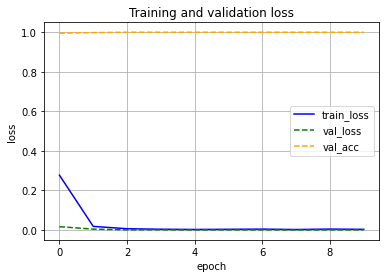

In [9]:
def main():
    config = vars(parse_args())

    if config['name'] is None:
        config['name'] = '%s_%s_%s_batch%s' % (config['dataset'], config['label'], config['arch'], config['batch_size'])
    print('orientation_pred_log/models/%s' % config['name'])
    os.makedirs('orientation_pred_log/models/%s' % config['name'], exist_ok=True)

    print('-' * 20)
    for key in config:
        print('%s: %s' % (key, config[key]))
    print('-' * 20)

    with open('orientation_pred_log/models/%s/config.yml' % config['name'], 'w') as f:
        yaml.dump(config, f)

    cudnn.benchmark = True
    img_ids_train, img_ids_test, img_labels_train, img_labels_test = label_maker(config)
    
    print("number of images in train ",len(img_ids_train), ", number of images in test ", len(img_ids_test)) 

    train_loader, val_loader = make_loader(img_ids_train, img_ids_test, img_labels_train, img_labels_test, config)
        
    #create model, optimizer, criterion 
    print("=> creating model %s" % config['arch'])
    model = archs.__dict__[config['arch']]()
    model = model.cuda() 
    params = filter(lambda p: p.requires_grad, model.parameters())
    criterion = losses.__dict__[config['loss']]().cuda()
    optimizer = optim_maker(params, config)
    log = OrderedDict([('epoch', []),('loss', []),('val_loss', []),('val_acc', [])])

    #create scheduler
    scheduler = scheduler_maker(optimizer, config)
    best_val_acc = 0
    for epoch in range(config['epochs']):
        print('Epoch [%d/%d]' % (epoch, config['epochs']))

        #model training
        train_log = train(train_loader, model, criterion, optimizer) 

        #model testing
        best_val_acc, df_log = val(val_loader, model, criterion, epoch, scheduler, config, train_log, log, best_val_acc)

    #visualization of learning process and improving accuracy
    print("best_val_acc", best_val_acc)
    fig_maker(df_log)

if __name__ == '__main__':
    main()

In [7]:
from dataset import make_loader_for_orientation
from train_val import pred_orient
from utils import cor_orient

In [10]:
def parse_args2():
    parser = argparse.ArgumentParser()

    parser.add_argument('--data_dir', default='input',
                        help='Directory containing the images to be aligned.')
    parser.add_argument('--output_dir', default='output',
                        help='Directory to put images with corrected orientation.')
    parser.add_argument('--img_path', default='D:/', type=str)
    parser.add_argument('--img_ext', default='.jpg',
                        help='image file extension')
    
    parser.add_argument('--output_w', default=630, type=int,
                        help='image width')
    parser.add_argument('--output_h', default=910, type=int,
                        help='image height')
    
    #parameter for trimming
    parser.add_argument('--trimming_one_hand', default=True,
                        help='Trimming the x-ray image of one hand after correcting the orientation.')
    parser.add_argument('--trim_ratio_one_hand_h', default=0.001, type=float,
                        help='Percentage of trimming the height of the x-ray image of one hand after correcting the orientation.')
    parser.add_argument('--trim_ratio_one_hand_w', default=0.001, type=float,
                        help='Percentage of trimming the width of the x-ray image of one hand after correcting the orientation.')

    parser.add_argument('--trimming_two_hand', default=True,
                        help='Trimming the x-ray image of one hand after correcting the orientation.')
    parser.add_argument('--trim_ratio_two_hand_h', default=0.001, type=float,
                        help='Percentage of trimming the height of the x-ray image of two hand after correcting the orientation.')
    parser.add_argument('--trim_ratio_two_hand_w', default=0.001, type=float,
                        help='Percentage of trimming the width of the x-ray image of two hand after correcting the orientation.')
    
    #parameter for resize

    parser.add_argument('--resize_one_hand', default=True,
                        help='Resize image of one_hand to the size of the output image.')
    parser.add_argument('--resize_two_hand', default=True,
                        help='Resize image of two_hand to the size of the output image.')
    
    config2 = parser.parse_args(args=['--data_dir', 'hand_test', '--img_path', '', '--output_dir','output', '--img_ext', '.png'])
    

    return config2

orientation_pred_log/models/hand_all_rotation_image_list_hand_ver3.csv_Effnet_batch64
===load_model===
ID_list ['test_img1', 'test_img2', 'test_img3', 'test_img4', 'test_img5', 'test_img6', 'test_img7', 'test_img8']
====  test_img1_L ====


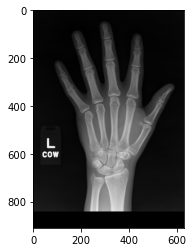

====  test_img2_L ====


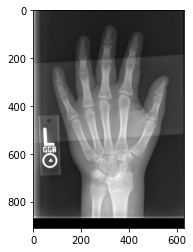

====  test_img3_L ====


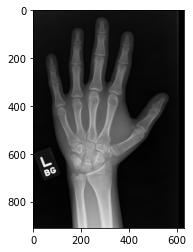

====  test_img4_L ====


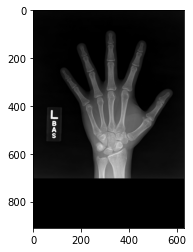

====  test_img5_L ====


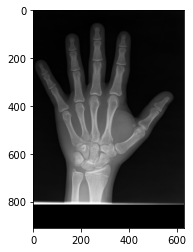

====  test_img5_R ====


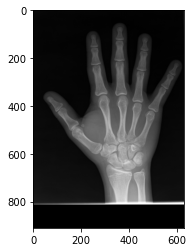

====  test_img6_L ====


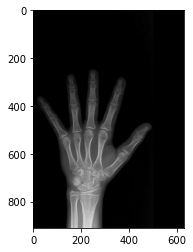

====  test_img6_R ====


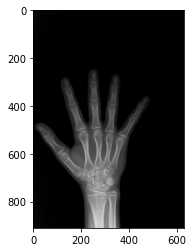

====  test_img7_L ====


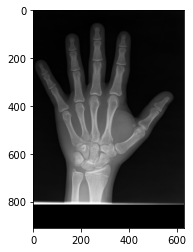

====  test_img7_R ====


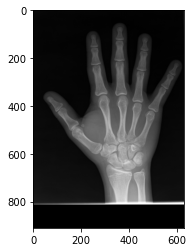

====  test_img8_L ====


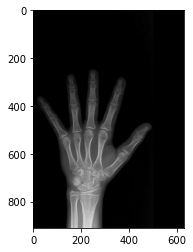

====  test_img8_R ====


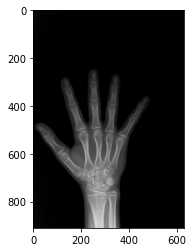

In [11]:
def main():
    config = vars(parse_args())
    config2 = vars(parse_args2())

    if config['name'] is None:
        config['name'] = '%s_%s_%s_batch%s' % (config['dataset'], config['label'], config['arch'], config['batch_size'])
    print('orientation_pred_log/models/%s' % config['name'])

    cudnn.benchmark = True

    img_list=[]
    for curDir, dirs, files in os.walk(config2['data_dir']):
        for i, file in enumerate(files):
            if file.endswith(config2['img_ext']):
                file = file[:-4]
                img_list.append(os.path.join(file))
    test_loader = make_loader_for_orientation(img_list, config, config2)
        
    #model loading
    model = archs.__dict__[config['arch']]()
    model = model.cuda() 
    params = filter(lambda p: p.requires_grad, model.parameters())

    # prediction
    pred_dataframe = pred_orient(test_loader, model, config, config2)

    cor_orient(pred_dataframe, config2)

if __name__ == '__main__':
    main()